# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor, isnan
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

tf.random.set_seed(1234)

Using TensorFlow backend.
2.1.0
1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["mj2", "mjdelta", "tau21j1", "tau21j2"] # Can be flexibly changed to suit GAN needs
condition_features = ["mjj"]

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["mjdelta"] = output_frame["mj1"] - output_frame["mj2"]
    output_frame["pj1"] = np.sqrt(output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["pj2"] = np.sqrt(output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pzj1"] + output_frame["pzj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters
BATCH_SIZE = 2048
EPOCHS = 2000

# Adam hyperparameters as recommended by arXiv:1704.00028
LEARNING_RATE = 1e-4
BETA_1 = 0
BETA_2 = 0.9

# WGAN hyperparameters
N_CRITIC = 5
C_LAMBDA = 10

In [5]:
df = load_data("pythiabg")

# Ensures all batches have same size

df.dropna(inplace = True)
df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [6]:
# Load sigdf to compare our results

sigdf = load_data("pythiasig")
sigdf.dropna(inplace = True)
sigdf.reset_index(drop = True, inplace = True)
sigdf = sigdf.astype('float32')

# Free up a bit of memory

sig_df = sigdf[train_features + condition_features]
del sigdf
gc.collect()

0

In [7]:
# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(df[train_features + condition_features])
feature_df = scaler.transform(df[train_features + condition_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


0

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features + condition_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(len(train_features + condition_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features + condition_features))

    return model

In [10]:
generator = make_generator_model()

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features + condition_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [12]:
discriminator = make_discriminator_model()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

In [14]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                300       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [15]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [16]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [17]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

In [19]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [20]:
@tf.function
def train_step_generator():
  noise = tf.concat([tf.random.normal([BATCH_SIZE, len(train_features)]), tf.random.uniform([BATCH_SIZE, len(condition_features)], minval=-1, maxval=1)], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [21]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])
  labels = tf.gather(images, [idx for idx in range(len(train_features), len(train_features) + len(condition_features))], axis=1)

  gen_input = tf.concat([noise, labels], 1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(gen_input, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features) + len(condition_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [22]:
@tf.function
def evaluate_generator():
    noise = tf.concat([tf.random.normal([BATCH_SIZE, len(train_features)]), tf.random.uniform([BATCH_SIZE, len(condition_features)], minval=-1, maxval=1)], 1)
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [23]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    labels = tf.gather(images, [idx for idx in range(len(train_features), len(train_features) + len(condition_features))], axis=1)

    gen_input = tf.concat([noise, labels], 1)

    generated_images = generator(gen_input, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features) + len(condition_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [24]:
def graph_gan(generator, signal = False):
    if signal:
        realdata = np.array(sig_df)
    else:
        realdata = scaler.inverse_transform(X_train)

    mjjmin = np.min(sig_df["mjj"])
    mjjmax = np.max(sig_df["mjj"])

    mjjmin_scaled = scaler.scale_[-1] * (mjjmin - scaler.min_[-1]) - 1
    mjjmax_scaled = scaler.scale_[-1] * (mjjmax - scaler.min_[-1]) - 1

    if signal:
        random_labels = np.random.uniform(low = mjjmin_scaled, high = mjjmax_scaled, size = (10000, 1))
    else:
        random_labels = np.random.uniform(low = -1, high = 1 - (mjjmax_scaled - mjjmin_scaled), size = (10000, 1))
        random_labels += (mjjmax_scaled - mjjmin_scaled) * (random_labels > mjjmin_scaled)

    fakedata = scaler.inverse_transform(generator(tf.concat([tf.random.normal((10000, len(train_features))),random_labels],1), training=False))
    
    f, a = plt.subplots(2, 2, constrained_layout=True)

    if signal:
        f.suptitle("Signal Regional Generation")
        label = "Pythia Signal"
    else:
        f.suptitle("Sideband Generation")
        label = "Pythia Background"

    a[0, 0].set_title("Subleading Jet Mass")
    a[0, 0].set_ylabel("Normalized to Unity")
    a[0, 0].set_xlabel("$m_{J_2}$")
    a[0, 0].hist(realdata[:,0], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 0].hist(fakedata[:,0], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    a[0, 1].set_title("Leading-Subleading Jet Mass Delta")
    a[0, 1].set_ylabel("Normalized to Unity")
    a[0, 1].set_xlabel("$m_{J_1}-m_{J_2}$")
    a[0, 1].hist(realdata[:,1], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 1].hist(fakedata[:,1], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    a[0, 1].legend(loc="upper right")

    a[1, 0].set_title("N-subjettiness ratio")
    a[1, 0].set_ylabel("Normalized to Unity")
    a[1, 0].set_xlabel("$\\tau_{21J_1}$")
    a[1, 0].hist(realdata[:,2], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 0].hist(fakedata[:,2], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    
    a[1, 1].set_title("N-subjettiness ratio")
    a[1, 1].set_ylabel("Normalized to Unity")
    a[1, 1].set_xlabel("$\\tau_{21J_2}$")
    a[1, 1].hist(realdata[:,3], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 1].hist(fakedata[:,3], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    plt.show()

In [25]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [26]:
def graph_losses():
    f, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

    f.suptitle("Loss Functions")

    ax1.set_title("Generator Loss")
    ax1.set_ylabel("Wasserstein Loss")
    ax1.set_xlabel("Epoch")
    ax1.plot(train_gen_losses, 'b', label = "Training loss")
    ax1.plot(test_gen_losses, 'r', label = "Validation loss")
    ax1.legend(loc="upper right")

    ax2.set_title("Discriminator Loss")
    ax2.set_ylabel("Wasserstein Loss")
    ax2.set_xlabel("Epoch")
    ax2.plot(train_disc_losses, 'b', label = "Training loss")
    ax2.plot(test_disc_losses, 'r', label = "Validation loss")

    plt.show()

In [27]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False #((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 50 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for batchnum, image_batch in enumerate(dataset):
      if random.random() < 1 / n_critic:
        train_gen_loss += K_eval(train_step_generator()) / len_dataset * n_critic
      train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
    
    train_gen_losses.append(train_gen_loss)
    train_disc_losses.append(train_disc_loss)

    # Evaluation

    for batchnum, test_batch in enumerate(testset):
      test_gen_loss += K_eval(evaluate_generator()) / len_testset
      test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

    test_gen_losses.append(test_gen_loss)
    test_disc_losses.append(test_disc_loss)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator, signal = False)
      graph_gan(generator, signal = True)
      graph_losses()

  2%|▏         | 49/2000 [01:45<1:07:07,  2.06s/it]
Epoch 50:


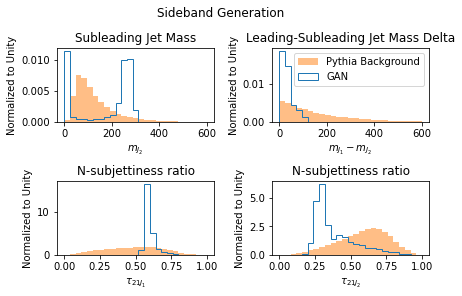

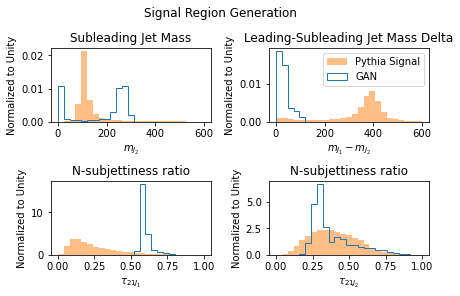

  2%|▏         | 49/2000 [01:50<1:13:06,  2.25s/it]


TypeError: 'Text' object is not callable

In [58]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

## Results
???